# Predict Cryptocurrency Prices With Machine Learning #

In [10]:
import numpy as np # working with data
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import utilities

### Step 1 Load & Process Data

In [11]:
currency = "BTC"
if currency == "BTC":
    utilities.fetch_historical_bitcoin_data_to_date()
    currency_data = utilities.get_dataset(currency=currency)
    
currency_close_price = currency_data.close.values.astype('float32')
currency_close_price = currency_close_price.reshape(len(currency_close_price), 1)

In [12]:
def create_datasets(dataset, sequence_length):
    sequence_length += 1
    seq_dataset = []
    for i in range(len(dataset) - sequence_length):
        seq_dataset.append(dataset[i: i + sequence_length])

    seq_dataset = np.array(seq_dataset)
    
    data_x = seq_dataset[:, :-1]
    data_y = seq_dataset[:, -1]
        
    return data_x, data_y

scaler = MinMaxScaler(feature_range=(0, 1))
currency_close_price_scaled = scaler.fit_transform(currency_close_price)

train_size = int(len(currency_close_price_scaled) * 0.85)
test_size = len(currency_close_price_scaled) - train_size
train, test = currency_close_price_scaled[0:train_size,:], currency_close_price_scaled[train_size:len(currency_close_price_scaled),:]

look_back = 10

x_train, y_train = create_datasets(train, look_back)
x_test, y_test = create_datasets(test, look_back)


### Step 2 Build Model

In [13]:
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.35))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.35))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='rmsprop')

/Users/oscaralsing/Documents/Programming/Predict-Cryptocurrency-Price-With-Machine-Learning/env/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/Users/oscaralsing/Documents/Programming/Predict-Cryptocurrency-Price-With-Machine-Learning/env/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  
/Users/oscaralsing/Documents/Programming/Predict-Cryptocurrency-Price-With-Machine-Learning/env/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  from ipykernel import kernelapp as app


In [14]:
history = model.fit(x_train, y_train, batch_size=64, epochs=30, verbose=2, validation_split=0.2)

Train on 1071 samples, validate on 268 samples
Epoch 1/30
 - 2s - loss: 1.6244e-04 - val_loss: 1.9826e-04
Epoch 2/30
 - 0s - loss: 9.1216e-05 - val_loss: 3.7961e-04
Epoch 3/30
 - 0s - loss: 9.1534e-05 - val_loss: 5.4648e-04
Epoch 4/30
 - 0s - loss: 5.8420e-05 - val_loss: 8.5976e-05
Epoch 5/30
 - 0s - loss: 4.8336e-05 - val_loss: 4.1925e-04
Epoch 6/30
 - 0s - loss: 5.4319e-05 - val_loss: 3.9451e-05
Epoch 7/30
 - 0s - loss: 4.5126e-05 - val_loss: 9.1595e-05
Epoch 8/30
 - 0s - loss: 3.7041e-05 - val_loss: 2.5251e-05
Epoch 9/30
 - 0s - loss: 4.5154e-05 - val_loss: 8.9752e-05
Epoch 10/30
 - 0s - loss: 2.9065e-05 - val_loss: 2.2867e-05
Epoch 11/30
 - 0s - loss: 3.2082e-05 - val_loss: 2.7509e-05
Epoch 12/30
 - 0s - loss: 4.0751e-05 - val_loss: 1.7106e-04
Epoch 13/30
 - 0s - loss: 2.3978e-05 - val_loss: 1.2708e-05
Epoch 14/30
 - 0s - loss: 3.1256e-05 - val_loss: 6.8804e-05
Epoch 15/30
 - 0s - loss: 2.5885e-05 - val_loss: 1.2752e-05
Epoch 16/30
 - 0s - loss: 2.7099e-05 - val_loss: 5.0289e-05
Ep

dict_keys(['val_loss', 'loss'])


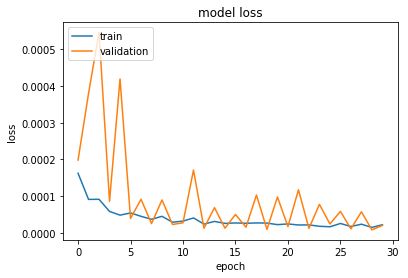

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

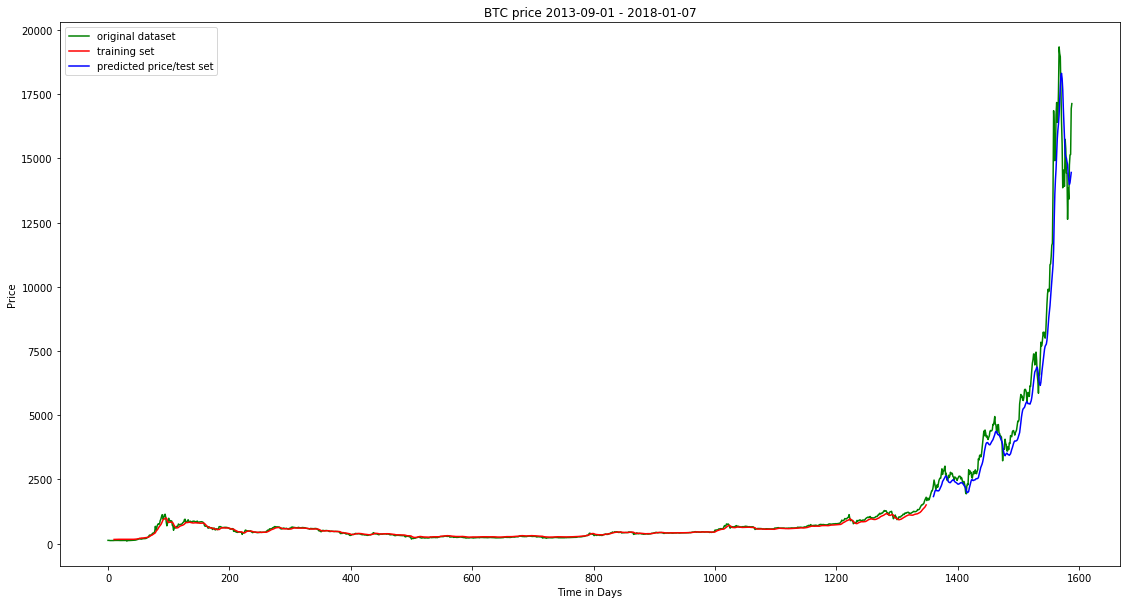

In [18]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

train_predict_unnorm = scaler.inverse_transform(train_predict)
test_predict_unnorm = scaler.inverse_transform(test_predict)

# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(currency_close_price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict_unnorm)+look_back, :] = train_predict_unnorm

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(currency_close_price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_unnorm)+(look_back*2)+1:len(currency_close_price)-1, :] = test_predict_unnorm

#futurePredictPlot = np.empty_like(currency_close_price)
#futurePredictPlot[:, :] = np.nan
#futurePredictPlot = np.append(futurePredictPlot, predict_days_forward(10))

plt.figure(figsize=(19, 10))
plt.plot(currency_close_price, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted price/test set')
#plt.plot(futurePredictPlot, 'y', label = 'future price')
plt.legend(loc = 'upper left')
plt.xlabel('Time in Days')
plt.ylabel('Price')

plt.title("%s price %s - % s" % (currency, 
                                 utilities.get_date_from_current(offset=len(currency_close_price)), 
                                 utilities.get_date_from_current(0)))

plt.show()
